# Assignment 1 for FIT5212, Semester 1

**Student Name:**  Han Li

**Student ID:**  32710542

## Part 1:  Text Classification

General comments and any shared processing here.

## Set up
##### Below block is for loading all libraries required for the project and preliminary set up including device and seed


In [ ]:
#For data loading and manipulation
import numpy as np
import pandas as pd

#For data visulisation
%matplotlib inline
import matplotlib.pyplot as plt
#pip install plotly
import plotly.express as px
import plotly as py

#For preprocssing
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import nltk
from nltk import PorterStemmer,WordNetLemmatizer,wordpunct_tokenize,word_tokenize
from nltk.corpus import stopwords
import spacy
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re

#For Modelling
#pip install xgboost
#pip install lightgbm
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F


#For performance metrics, data spliting
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (confusion_matrix,f1_score,ConfusionMatrixDisplay,
                             precision_score,accuracy_score,
                             recall_score,matthews_corrcoef,precision_recall_curve)

#For Model tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,train_test_split

#Utilities
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
import random
import os
import re

This task is to train a statistic NLP model for classify artical class by either Abstract or Titles. To do so I will be applying 2 different preprocessing configuration

In [ ]:
# Seed for reprodiction
SEED = 23
def seeding(SEED = SEED):
    """SEED: int number define by variable SEED"""
    np.random.seed(SEED)
    random.seed(SEED)
    torch.manual_seed(SEED)
seeding() 

# Setting up cuda for Colab GPU runtime and mps for ARM enviroment
# The code will be test under macos arm with mps support and Colab GPU runtime with cuda support
device = torch.device('cuda' if 
torch.cuda.is_available() else 'mps')

### Data Loading

In [ ]:
#Assert train.csv and test.csv are in working directory
train_dir = (os.getcwd() +'/train.csv' if 'train.csv' in os.listdir() else print('training set not in working directory'))
test_dir = (os.getcwd() +'/test.csv' if 'test.csv' in os.listdir() else print('testing set not in working directory'))

#Load datasets
df_train = pd.read_csv(train_dir)
df_test = pd.read_csv(test_dir)

In [ ]:
#Inspect train and test data
df_train.sample(10)
df_test.sample(5)

# Preprocessing
## For easy access, I will wrap all necessary steps for preprocessing in 1 single class
#### Step 1: Training,Validation split (df_train_val_split)
##### This is to split the entire training set into training and validation set basic on task requirement


#### Step 2: preprocessing(preprocess) 
##### This is to preprocess the data using 2 different method
##### Method 1: Text to be lower, remove stopword, paranthesis and other special charaters,spaces and apply porter stemmer and tfidf vectorizer
##### Method 2: Text to be lower, remove special charaters,spaces and apply lemmatizer and countvectorizer

#### Step 3:Clean(clean) 
##### This is to combine the above method and apply the cleaning to each input(text) of the datasett

In [ ]:
class preprocesser:
    """
    How to use:
    Initialize preprocesser 
    e.g. prep = preporcesser()

    Obtain X,y for training and validation set using only the clean function 
    e.g. X_train,X_val,y_train,y_val = prep.clean(task = 'InformationTheory',size = 'sample',
                                                input = 'abstract',method = 2)
    """

    class LemmaTokenizer(object):
        def __init__(self):
            self.wnl = WordNetLemmatizer()

        def __call__(self, doc):
            return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]


    class SteamTokenizer(object):
        def __init__(self):
            self.ps = PorterStemmer()

        def __call__(self, doc):
            return [self.ps.stem(t) for t in word_tokenize(doc)]
        
    def __init__(self):
        self.df = df_train
        self.lemma = self.LemmaTokenizer()
        self.steam  = self.SteamTokenizer()

        self.stem_vectorizer = TfidfVectorizer(
                                  tokenizer=self.steam)
        self.LemmaTokenizer = CountVectorizer(
            tokenizer=self.lemma
)

    def df_train_val_split(self, task, input, size):
        
        """
        task:Dependent variables can be choose from ['InformationTheory','ComputationalLinguistics','ComputerVision']

        input:independent variable that can be choose from ['title','abstract']

        size = select from ['full','sample'] to return either 10% or entire training set

        df_train_1k, df_val_1k: The first 1000 sample of the df_train set(900 inputs), and split 10% as validation set(100 inputs)

        df_train_all, df_val_all: The entire training data(112500 inputs) excluding 10% as validation set(12500 inputs)

        Return: X_train,X_val,y_train,y_val the training and validation value as list for both X and y variables
        """
        # Assert inputs meets function requirement
        assert input in [
            'title', 'abstract'], 'Please ensure input is choosen from title and abstract'
        assert task in ['InformationTheory', 'ComputationalLinguistics',
                        'ComputerVision'], 'Please ensure column name you wish to predict are correct'
        assert size in ['full', 'sample'], 'choose only full or sample dataset'

        if size == 'sample':
            df_1k = self.df.sample(1000).reset_index(drop=True)
            df_train_1k, df_val_1k = train_test_split(df_1k, test_size=.1)
            X_train = df_train_1k[input].tolist()
            X_val = df_val_1k[input].tolist()
            y_train = df_train_1k[task].tolist()
            y_val = df_val_1k[task].tolist()

        elif size == 'full':
            df_train_all, df_val_all = train_test_split(self.df, test_size=.1)
            X_train = df_train_all[input].tolist()
            X_val = df_val_all[input].tolist()
            y_train = df_train_all[task].tolist()
            y_val = df_val_all[task].tolist()
        return X_train, X_val, y_train, y_val


    def preprocess(self,text,method = 1):
        """
        text :raw text from dataset input
        method: int 1 or 2, refer to differetn preprocessing method
        Method 1: Text to be lower, remove stopword, paranthesis and other special charaters,spaces and apply porter stemmer and tfidf vectorizer
        Method 2: Text to be lower, remove special charaters,spaces and apply lemmatizer and countvectorizer
        """
        assert method in [1,2],'Please select 1 or 2 only'
        STOPWORDS = set(stopwords.words('english'))

        # Lower
        text = text.lower()
        # Remove Special characters
        text = re.sub(r'\n','',text)
        # Spacing and filters
        text = re.sub(r"([-;;.,!?<=>])", r" \1 ", text)
        text = re.sub('[^A-Za-z0-9]+', ' ', text) # remove non alphanumeric chars
        text = re.sub(' +', ' ', text)  # remove multiple spaces
        text = text.strip() 

        if method == 1:
            # Remove stopwords
            pattern = re.compile(r'\b(' + r'|'.join(STOPWORDS) + r')\b\s*')
            text = pattern.sub('', text)
            # Remove words in paranthesis
            text = re.sub(r'\([^)]*\)', '', text)

        else:
            pass

        return text
    
    def clean(self,task,size,input,method):
        """
        Task,input,size = require argument for df_train_val_split
        method = require argument ofr preprocess
        """
        X_train, X_val, y_train, y_val = self.df_train_val_split(task,input,size)

        if method == 1:
            X_train = [self.preprocess(i,method =1 ) for i in X_train]
            X_train = self.stem_vectorizer.fit_transform(X_train).astype(np.float64)
            X_val = [self.preprocess(i,method =1) for i in X_val]
            X_val = self.stem_vectorizer.transform(X_val).astype(np.float64)
        elif method == 2:
            X_train = [self.preprocess(i,method =2 ) for i in X_train]
            X_train = self.LemmaTokenizer.fit_transform(X_train).astype(np.float64)
            X_val = [self.preprocess(i,method =2 ) for i in X_val]
            X_val = self.LemmaTokenizer.transform(X_val).astype(np.float64)
        y_train = np.asarray(y_train)
        y_val =np.asanyarray(y_val)
        return X_train,X_val,y_train,y_val
    
    


# Training
## All functions are wrapped in class training as above
#### Step 1: Model Selection(model_selection)
##### Using accuracy as metric, I will run a k fold cross validation for each model in the model dictionary, and return the best model base on the average accuracy over the k runs

#### Step 2: Fine Tuning (fine_tuning) 
##### Using the best model from step 1, this function will conduct a grid serach to fine the best parameter of the best model. Returing a predition of y, i.e. y_pred

#### Step 3:Drawing the Confusion Matrix and Precision recall curve (draw_metrix) 
##### This is draw the confusion matrix and PR Curve between y_pred and y_true. Also display the f1,precison,recall and accuracy score

In [11]:
class training:
    """
    How to use:
    Initialize training 
    e.g. train = training()

    Using draw_metric it will automatecally draw the Confusion matrix and precision recall curve
    your can also assign y_pred to it to obtain the prediction y
    e.g. y_pred = tra.draw_metric(CV = 2,X = X_train,Y = y_train, X_val = X_val,y_val = y_val,
                                i = i,m = m,t = t,s =s)
    
    """
    def __init__(self):
        """
        In here we also defined 2 dictionals to locate the require model and parameter as needed
        """
        self.models = {
    'AdaBoostClassifier': AdaBoostClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'XGBClassifier': XGBClassifier(),
    'LGBMClassifier': lgb.LGBMClassifier(),
    'BaggingClassifier': BaggingClassifier()}
        
        self.param_grid = {
        'AdaBoostClassifier': {
            'learning_rate': np.arange(0.001, 1, 0.05),
            'n_estimators': range(10, 500, 10),
            'algorithm': ['SAMME', 'SAMME.R']
        },
        'RandomForestClassifier': {
            'n_estimators': range(10, 500, 10),
            'criterion': ['gini', 'entropy'],
            'max_features': ['sqrt', 'log2']
        },
        'DecisionTreeClassifier': {
            'criterion': ['gini', 'entropy'],
            'splitter': ['best', 'random'],
            'max_depth': range(1, 16, 2)
        },
        'XGBClassifier': {
            'learning_rate': np.arange(0.001, 1, 0.05),
            'n_estimators': range(10, 500, 10),
            'max_depth': range(1, 16, 2),
            'subsample': np.arange(0, 1, 0.1),
            'colsample_bytree': np.arange(0, 1, 0.1)
        },
        'LGBMClassifier': {
            'learning_rate': np.arange(0.001, 1, 0.05),
            'n_estimators': range(10, 500, 10),
            'max_depth': range(1, 16, 2),
            'subsample': np.arange(0, 1, 0.1),
            'colsample_bytree': np.arange(0, 1, 0.1),
            'feature_fraction':np.arange(0.1,1,0.1),
            'bagging_fraction':np.arange(0.1,1,0.1)
        },
        'BaggingClassifier': {
            'n_estimators': range(10, 500, 10),
            'max_samples': np.arange(0.1, 1, 0.1),
            'max_features': np.arange(0.1, 1, 0.1)
        }}

    def model_selection(self,CV,X_train,y_train):
        """
        CV:number of Cross validation
        NEED TO FIX
        """
        cv_df = pd.DataFrame(index = range(CV *len(self.models)))
        entries = []
        for mod_name,model in self.models.items():
            accs = cross_val_score(model,X_train,y_train,scoring = 'accuracy',cv = CV)
            for cv_idx,acc in enumerate(accs):
                entries.append((mod_name,cv_idx,acc))
        cv_df  = pd.DataFrame(entries,columns=['model_name', 'fold_idx', 'accuracy'])
        best_model_name = cv_df.groupby('model_name')['accuracy'].mean().sort_values(ascending=False).index[0]
        print(f"The Most accuray model is {best_model_name}")
        return best_model_name
    
    def fine_tuning(self,CV,X,Y,X_val):
        """ 
        CV:number of Cross validation
        X:The independent variables
        Y:The Dependent variables
        X
        """
        best_model_name = self.model_selection(CV,X,Y)
        randomized_scv = RandomizedSearchCV(
            estimator=self.models[best_model_name],
            param_distributions = self.param_grid[best_model_name],
            n_iter = 20,
            scoring= 'accuracy',
            cv = CV,
            random_state= 1,
            n_jobs = -1
        ).fit(X,Y)
        best_model = randomized_scv.best_estimator_
        best_model.fit(X,Y)
        y_pred = best_model.predict(X_val)
        return y_pred
    
    def draw_metric(self,CV,X,Y,X_val,y_val,i = None,m = None,t = None,s =None):
        y_pred = self.fine_tuning(CV,X,Y,X_val)
        print(f"The F1 Score for this setting is {f1_score(y_val,y_pred):.3f}")
        print(f"The recall for this setting is {recall_score(y_val,y_pred):.3f}")
        print(f"The Precision for this setting is {precision_score(y_val,y_pred):.3f}")
        print(f"The accuracy for this setting is {accuracy_score(y_val,y_pred):.3f}")
        
        cm = confusion_matrix(y_val,y_pred)
        fig,(ax1,ax2) = plt.subplots(1,2,figsize = (15,5))
        if i != None:
            fig.suptitle(f"Setting: Input: {i} Method: {m}, Task: {t}, size: {s}")
        ax1.imshow(cm,cmap = 'Spectral')
        ax1.set_title('Confusion Matrix')
        ax1.set_xlabel('Predicted Label')
        ax1.set_ylabel('True Label')
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax1.text(j, i, str(cm[i, j]), ha='center', va='center')
        ax1.grid(False)
        precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
        ax2.fill_between(recall, precision)
        ax2.set_ylabel("Precision")
        ax2.set_xlabel("Recall")
        ax2.set_title("Precision-Recall curve")
        ax2.plot(recall,precision)
        plt.show()
        return y_pred

In [ ]:
prep = preprocesser()
X_train,X_val,y_train,y_val = prep.clean(task = 'ComputationalLinguistics',size = 'sample',input = 'abstract',method = 2)

#######################################
Iter1
The Most accuray model is AdaBoostClassifier
The F1 Score for this setting is 0.667
The recall for this setting is 0.571
The Precision for this setting is 0.800
The accuracy for this setting is 0.880


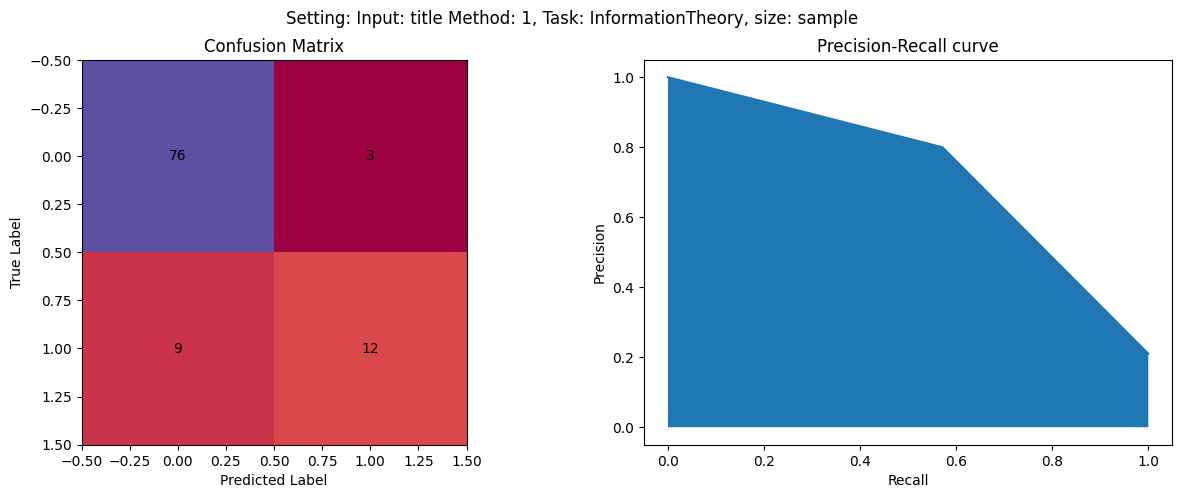

#######################################
                                             
#######################################
Iter2


KeyboardInterrupt: 

In [14]:
prep = preprocesser()
tra = training()
input = ['title', 'abstract']
method = [1,2]
task = ['InformationTheory', 'ComputationalLinguistics','ComputerVision']
size = ['sample','full']
Round = 0
results_df = pd.DataFrame(columns=['input', 'method', 'task', 'size', 'f1_score'])

for i in input:
    for m in method:
        for t in task:
            for s in size:
                Round+=1
                X_train,X_val,y_train,y_val = prep.clean(input = i,method = m,task = t,size =s)
                print('#######################################')
                print(f"Iter{Round} Paramter input: {i}, method: {m}, task: {t}, size: {s}")
                y_pred = tra.draw_metric(CV = 5,X = X_train,Y = y_train, X_val = X_val,y_val = y_val,
                                i = i,m = m,t = t,s =s)
                print('#######################################')
                print('                                             ')
                results_df = results_df.append({"Iter":Round,'input': i, 'method': m, 'task': t, 'size': s, 
                                                'f1_score': f1_score(y_val,y_pred), "recall":recall_score(y_val,y_pred),
                                                'Precision':precision_score(y_val,y_pred),
                                                'accuracy':accuracy_score(y_val,y_pred)}, ignore_index=True)


In [ ]:
results_df

,input,method,task,size,f1_score,Iter,recall,Precision,accuracy
0,title,1,InformationTheory,sample,0.818182,1.0,0.720000,0.947368,0.92
1,title,1,ComputationalLinguistics,sample,0.687500,2.0,0.611111,0.785714,0.90
2,title,1,ComputerVision,sample,0.800000,3.0,0.830189,0.771930,0.78
3,title,2,InformationTheory,sample,0.784314,4.0,0.689655,0.909091,0.89
4,title,2,ComputationalLinguistics,sample,0.484848,5.0,0.333333,0.888889,0.83
5,title,2,ComputerVision,sample,0.881720,6.0,0.854167,0.911111,0.89
6,abstract,1,InformationTheory,sample,0.888889,7.0,0.833333,0.952381,0.95
7,abstract,1,ComputationalLinguistics,sample,0.857143,8.0,0.818182,0.900000,0.94
8,abstract,1,ComputerVision,sample,0.904348,9.0,0.962963,0.852459,0.89
9,abstract,2,InformationTheory,sample,0.943396,10.0,0.892857,1.000000,0.97
